In [1]:
!git clone https://github.com/nwfxyz/4D_analytics.git

Cloning into '4D_analytics'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.38 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [ ]:
# http://www.singaporepools.com.sg/en/product/Pages/4d_cpwn.aspx

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [59]:
plt.style.use('ggplot')

In [163]:
results = pd.read_csv('/content/4D_analytics/Results.csv', usecols=['DrawDate','PrizeCode','Digit'], parse_dates=['DrawDate'])
results.head()

,DrawDate,PrizeCode,Digit
0,2014-10-05,1,0
1,2014-09-06,2,0
2,2005-08-21,S,0
3,2006-05-14,S,0
4,2012-01-29,S,0


In [164]:
results.shape

(100156, 3)

In [165]:
results = results.sort_values(by='DrawDate')
results['digits']=results.Digit.apply(lambda x: f'{x:04d}')
results['D_list'] = pd.DataFrame(results.digits.apply(lambda x: [*x]))
DF = pd.DataFrame(results['D_list'].to_list(), columns=['d1', 'd2', 'd3', 'd4'], index=results.index)
results = pd.concat((results,DF),axis=1)
results.head()

,DrawDate,PrizeCode,Digit,digits,D_list,d1,d2,d3,d4
66474,1986-05-31,S,6619,6619,"[6, 6, 1, 9]",6,6,1,9
32802,1986-05-31,2,3277,3277,"[3, 2, 7, 7]",3,2,7,7
51499,1986-05-31,C,5131,5131,"[5, 1, 3, 1]",5,1,3,1
38963,1986-05-31,C,3883,3883,"[3, 8, 8, 3]",3,8,8,3
77262,1986-05-31,S,7709,7709,"[7, 7, 0, 9]",7,7,0,9


In [166]:
df = results.query("PrizeCode=='1' | PrizeCode=='2' | PrizeCode=='3' ")
df.head()

,DrawDate,PrizeCode,Digit,digits,D_list,d1,d2,d3,d4
32802,1986-05-31,2,3277,3277,"[3, 2, 7, 7]",3,2,7,7
86077,1986-05-31,3,8586,8586,"[8, 5, 8, 6]",8,5,8,6
88555,1986-05-31,1,8838,8838,"[8, 8, 3, 8]",8,8,3,8
46928,1986-06-01,3,4671,4671,"[4, 6, 7, 1]",4,6,7,1
43519,1986-06-01,1,4337,4337,"[4, 3, 3, 7]",4,3,3,7


In [167]:
df.columns

Index(['DrawDate', 'PrizeCode', 'Digit', 'digits', 'D_list', 'd1', 'd2', 'd3',
       'd4'],
      dtype='object')

In [168]:
df.shape

(13068, 9)

In [169]:
TRAIN_SPLIT = 4000
tf.random.set_seed(13)

In [170]:
df = df.sort_values(by=['DrawDate', 'PrizeCode'])
df.head(6)

,DrawDate,PrizeCode,Digit,digits,D_list,d1,d2,d3,d4
88555,1986-05-31,1,8838,8838,"[8, 8, 3, 8]",8,8,3,8
32802,1986-05-31,2,3277,3277,"[3, 2, 7, 7]",3,2,7,7
86077,1986-05-31,3,8586,8586,"[8, 5, 8, 6]",8,5,8,6
43519,1986-06-01,1,4337,4337,"[4, 3, 3, 7]",4,3,3,7
94392,1986-06-01,2,9419,9419,"[9, 4, 1, 9]",9,4,1,9
46928,1986-06-01,3,4671,4671,"[4, 6, 7, 1]",4,6,7,1


In [ ]:
# df.to_csv('4D_1986_2018.csv',index=False)

In [171]:
df.iloc[:,-4:]=df.iloc[:,-4:].astype('int8')

In [172]:
df.shape

(13068, 9)

In [16]:
df.shape[0]/3

4356.0

In [ ]:
import matplotlib.pyplot as plt

In [212]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(14,6))

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### LSTM

In [115]:
m = df.iloc[:,-4:].values
m.shape

(13068, 4)

In [116]:
m = m.reshape(-1,12)
m.shape

(4356, 12)

In [117]:
train = m[:TRAIN_SPLIT, :]
train.shape

(4000, 12)

In [118]:
valid = m[TRAIN_SPLIT:, :]
valid.shape

(356, 12)

In [150]:
def multivariate_data_all_one_v2(dataset,start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = dataset.shape[-1] - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices, :])

    labels.append(dataset[i])


  return np.array(data), np.array(labels)

In [213]:
history_size = 30
start_index=0
end_index = train.shape[0]-history_size
step = 1
target_size = 1

In [214]:
x_train, y_train = multivariate_data_all_one_v2(train, start_index, end_index, history_size,target_size, step, single_step=True)

In [215]:
start_index=0
end_index = valid.shape[0]-history_size
x_val, y_val = multivariate_data_all_one_v2(valid, start_index, end_index, history_size,target_size, step, single_step=True)

In [216]:
print(f'train: {x_train.shape}, valid:  {x_val.shape}')
print ('Single window of past history : {}'.format(x_train[0].shape))

train: (3940, 30, 12), valid:  (296, 30, 12)
Single window of past history : (30, 12)


In [217]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 8

In [218]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [219]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(12)]
)

In [220]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [221]:
for x,y in val_data.take(1):
  print(model.predict(x).shape)

(8, 12)


In [222]:
EPOCHS = 40
EVALUATION_INTERVAL = int(x_train.shape[0]/BATCH_SIZE)

In [223]:
history = model.fit(train_data, epochs=EPOCHS,validation_data=val_data,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_steps=33)

Epoch 1/40
492/492 [==============================] - 15s 31ms/step - loss: 2.5285 - val_loss: 2.5306
Epoch 2/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4964 - val_loss: 2.5200
Epoch 3/40
492/492 [==============================] - 18s 37ms/step - loss: 2.4982 - val_loss: 2.5177
Epoch 4/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4946 - val_loss: 2.5119
Epoch 5/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4974 - val_loss: 2.5224
Epoch 6/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4946 - val_loss: 2.5206
Epoch 7/40
492/492 [==============================] - 15s 31ms/step - loss: 2.4956 - val_loss: 2.5193
Epoch 8/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4925 - val_loss: 2.5195
Epoch 9/40
492/492 [==============================] - 15s 30ms/step - loss: 2.4911 - val_loss: 2.5276
Epoch 10/40
492/492 [==============================] - 15s 30ms/step - loss: 2.488

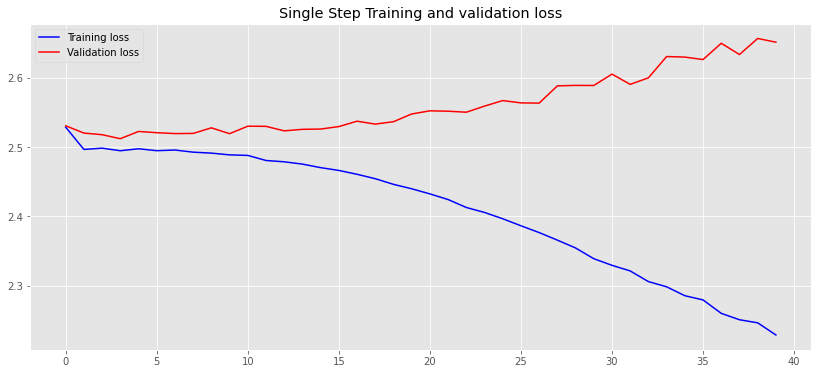

In [224]:
plot_train_history(history,'Single Step Training and validation loss')

In [225]:
for x, y in val_data.take(1):
  print(f'x shape: {x.shape}, y_shape: {y.shape}')
  print(f'prediction shape: {model.predict(x).shape}')

x shape: (8, 30, 12), y_shape: (8, 12)
prediction shape: (8, 12)


In [226]:
for X, Y in train_data.take(1):
  preds = np.round(model.predict(X),0)
  for p,y in zip(preds,Y):
    print(f'Label: {y[:4]}; Prediction: {p[:4]}')

Label: [6 3 9 9]; Prediction: [5. 5. 4. 6.]
Label: [1 7 0 3]; Prediction: [4. 4. 6. 4.]
Label: [0 6 0 0]; Prediction: [3. 6. 5. 3.]
Label: [8 3 9 4]; Prediction: [4. 3. 6. 4.]
Label: [8 5 4 5]; Prediction: [4. 3. 4. 3.]
Label: [1 9 5 9]; Prediction: [5. 6. 6. 5.]
Label: [4 8 8 1]; Prediction: [6. 5. 6. 4.]
Label: [4 6 8 2]; Prediction: [5. 5. 8. 6.]


# Wave Net

In [382]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 8
EPOCHS = 12
EVALUATION_INTERVAL = int(x_train.shape[0]/BATCH_SIZE)

## wave net windowed dataset

In [362]:
def create_ds_tensor(series, window_size, step):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+4, shift=step, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size+4))
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.map(lambda x: (x[:-4],x[4:]))
    ds = ds.batch(BATCH_SIZE).prefetch(1)
    return ds.repeat()

In [363]:
m = df.iloc[:,-4:].values
m = m.reshape(-1,12)
m.shape

(4356, 12)

In [367]:
window_size = 30*3*4
train = m[:TRAIN_SPLIT, :]
valid = m[TRAIN_SPLIT:, :]

In [368]:
train.shape

(4000, 12)

In [369]:
train_ds = create_ds_tensor(np.ravel(train), window_size=window_size, step=1)
valid_ds = create_ds_tensor(np.ravel(valid), window_size=window_size, step=1)

In [370]:
for i in train_ds.take(1):
  print(f'data: {i[0].shape}, labels: {i[1].shape}' )


data: (8, 360, 1), labels: (8, 360, 1)


In [371]:
for i in valid_ds.take(1):
  print(f'data: {i[0].shape}, labels: {i[1].shape}' )

data: (8, 360, 1), labels: (8, 360, 1)


In [375]:
model_mupltivariate = tf.keras.models.Sequential()
model_mupltivariate.add(tf.keras.layers.InputLayer(input_shape=[None,1]))

for dilation_rate in (1,2,4,8,16,32):
    model_mupltivariate.add(tf.keras.layers.Conv1D(filters=64, 
                                    kernel_size=2, 
                                    dilation_rate=dilation_rate,
                                    strides=1,
                                    padding='causal',
                                    activation='relu'
                                   ))
model_mupltivariate.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1, ))

In [376]:
model_mupltivariate.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(lr=1e-3),metrics=['mae'])

In [384]:
model_mupltivariate.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, None, 64)          192       
_________________________________________________________________
conv1d_72 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
conv1d_73 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, None, 1)         

In [377]:
history = model_mupltivariate.fit(train_ds, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                    validation_data=valid_ds, validation_steps=50)

Epoch 1/20
492/492 [==============================] - 23s 46ms/step - loss: 2.3428 - mae: 2.3428 - val_loss: 2.8143 - val_mae: 2.8143
Epoch 2/20
492/492 [==============================] - 23s 46ms/step - loss: 1.7204 - mae: 1.7204 - val_loss: 2.9538 - val_mae: 2.9538
Epoch 3/20
492/492 [==============================] - 23s 46ms/step - loss: 1.5545 - mae: 1.5545 - val_loss: 2.9684 - val_mae: 2.9684
Epoch 4/20
492/492 [==============================] - 23s 46ms/step - loss: 1.5079 - mae: 1.5079 - val_loss: 2.9674 - val_mae: 2.9674
Epoch 5/20
492/492 [==============================] - 23s 47ms/step - loss: 1.4423 - mae: 1.4423 - val_loss: 3.0469 - val_mae: 3.0469
Epoch 6/20
492/492 [==============================] - 23s 46ms/step - loss: 1.4275 - mae: 1.4275 - val_loss: 3.0485 - val_mae: 3.0485
Epoch 7/20
492/492 [==============================] - 23s 46ms/step - loss: 1.3876 - mae: 1.3876 - val_loss: 3.1122 - val_mae: 3.1122
Epoch 8/20
492/492 [==============================] - 23s 46ms

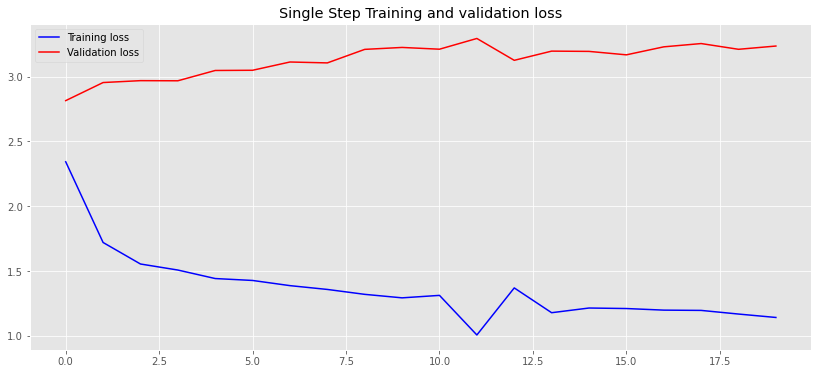

In [380]:
plot_train_history(history,'Single Step Training and validation loss')

In [388]:
for X, Y in train_ds.take(1):
  print(X.shape)

(8, 360, 1)


In [390]:
for X, Y in train_ds.take(1):
  preds = np.round(model_mupltivariate.predict(X),0)
  for p,y in zip(preds,Y):
    print(f'Label: {np.ravel(y[:4])}; Prediction: {np.ravel(p[:4])}')

Label: [9 0 5 4]; Prediction: [4. 5. 5. 4.]
Label: [0 9 5 1]; Prediction: [4. 4. 4. 4.]
Label: [0 4 4 6]; Prediction: [5. 6. 5. 6.]
Label: [5 2 0 8]; Prediction: [4. 4. 5. 5.]
Label: [2 0 1 8]; Prediction: [4. 5. 5. 6.]
Label: [6 5 1 9]; Prediction: [4. 6. 5. 4.]
Label: [0 4 1 7]; Prediction: [4. 4. 4. 4.]
Label: [0 0 6 2]; Prediction: [5. 5. 6. 5.]


# Visualization

In [7]:
df = df.reset_index(drop=True)
df.head()

,DrawDate,PrizeCode,Digit,digits,D_list,d1,d2,d3,d4
0,1986-05-31,2,3277,3277,"[3, 2, 7, 7]",3,2,7,7
1,1986-05-31,3,8586,8586,"[8, 5, 8, 6]",8,5,8,6
2,1986-05-31,1,8838,8838,"[8, 8, 3, 8]",8,8,3,8
3,1986-06-01,3,4671,4671,"[4, 6, 7, 1]",4,6,7,1
4,1986-06-01,1,4337,4337,"[4, 3, 3, 7]",4,3,3,7


In [10]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

## Histograms

In [71]:
fig = px.histogram(df, x='d1')
fig.show()

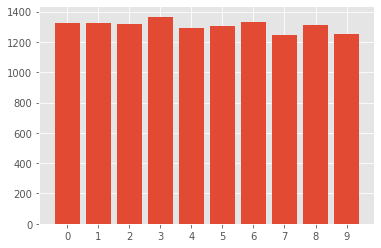

In [60]:
counter, digits = np.histogram(df.d1.values,bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.bar(digits[:-1],counter)
plt.xticks(digits[:-1])
plt.show()

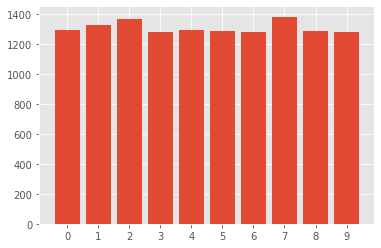

In [65]:
counter, digits = np.histogram(df.d2.values,bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.bar(digits[:-1],counter)
plt.xticks(digits[:-1])
plt.show()

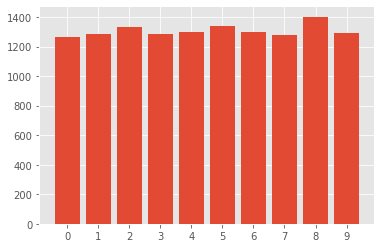

In [66]:
counter, digits = np.histogram(df.d3.values,bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.bar(digits[:-1],counter)
plt.xticks(digits[:-1])
plt.show()

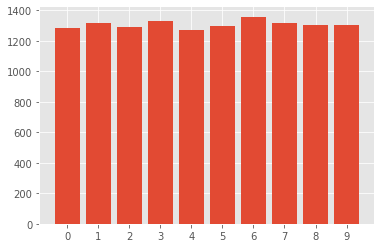

In [67]:
counter, digits = np.histogram(df.d4.values,bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.bar(digits[:-1],counter)
plt.xticks(digits[:-1])
plt.show()

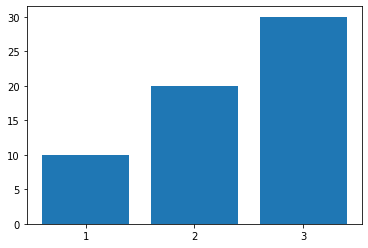

In [14]:
plt.bar([1,2,3],[10,20,30])
plt.xticks([1,2,3])
plt.show()

In [72]:
fig = px.histogram(df, x='d2')
fig.show()

In [73]:
fig = px.histogram(df, x='d3')
fig.show()

In [74]:
fig = px.histogram(df, x='d4')
fig.show()

In [79]:
# The most frequent digits
df.iloc[:,-4:].mode(axis=0)

,d1,d2,d3,d4
0,3,7,8,6


In [82]:
df.iloc[:,-4:].values.reshape(-1,1).shape

(52272, 1)

In [91]:
np.ravel(df.iloc[:,-4:].values).shape

(52272,)

In [94]:
trace= go.Histogram(x=np.ravel(df.iloc[:,-4:].values))
fig=go.Figure(data=[trace])
fig.show()

## Cross presence matrix

In [95]:
df.head()

,DrawDate,PrizeCode,Digit,digits,D_list,d1,d2,d3,d4
0,1986-05-31,1,8838,8838,"[8, 8, 3, 8]",8,8,3,8
1,1986-05-31,2,3277,3277,"[3, 2, 7, 7]",3,2,7,7
2,1986-05-31,3,8586,8586,"[8, 5, 8, 6]",8,5,8,6
3,1986-06-01,1,4337,4337,"[4, 3, 3, 7]",4,3,3,7
4,1986-06-01,2,9419,9419,"[9, 4, 1, 9]",9,4,1,9


In [100]:
df.columns

Index(['DrawDate', 'PrizeCode', 'Digit', 'digits', 'D_list', 'd1', 'd2', 'd3',
       'd4'],
      dtype='object')

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [69]:
# F = df.iloc[:,-4:]
F = df[['DrawDate', 'd1', 'd2', 'd3','d4']]
F.head()

,DrawDate,d1,d2,d3,d4
88555,1986-05-31,8,8,3,8
32802,1986-05-31,3,2,7,7
86077,1986-05-31,8,5,8,6
43519,1986-06-01,4,3,3,7
94392,1986-06-01,9,4,1,9


In [70]:
tab = pd.pivot_table(F,index=['d1','d2'], values='DrawDate', columns=['d3','d4'],aggfunc='count')
tab

d3       0                                ...    9                              
d4       0    1    2    3    4    5    6  ...    3    4    5    6    7    8    9
d1 d2                                     ...                                   
0  0   2.0  2.0  1.0  NaN  NaN  1.0  3.0  ...  3.0  6.0  1.0  NaN  3.0  1.0  2.0
   1   2.0  1.0  1.0  1.0  NaN  NaN  1.0  ...  1.0  1.0  1.0  2.0  2.0  2.0  3.0
   2   1.0  NaN  6.0  1.0  3.0  1.0  2.0  ...  2.0  NaN  NaN  4.0  5.0  3.0  1.0
   3   1.0  1.0  1.0  2.0  1.0  1.0  2.0  ...  1.0  1.0  NaN  NaN  2.0  NaN  1.0
   4   2.0  2.0  NaN  1.0  1.0  NaN  NaN  ...  NaN  NaN  2.0  1.0  NaN  2.0  3.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
9  5   3.0  4.0  1.0  1.0  2.0  1.0  4.0  ...  1.0  NaN  NaN  NaN  1.0  NaN  1.0
   6   NaN  4.0  5.0  1.0  2.0  NaN  NaN  ...  2.0  1.0  1.0  2.0  1.0  1.0  1.0
   7   NaN  1.0  1.0  2.0  2.0  NaN  3.0  ...  2.0  1.0  2.0  NaN  1.0  2.0  NaN
   8   1.0  1.0  2.0  NaN  2.0  2.0  3.0  ...  NaN  1.0  3.0  1.0  2.0  2.0  2.0
   9   1.0  1.0  NaN  NaN  2.0  NaN  3.0  ...  1.0  1.0  1.0  3.0  1.0  NaN  NaN

[100 rows x 100 columns]

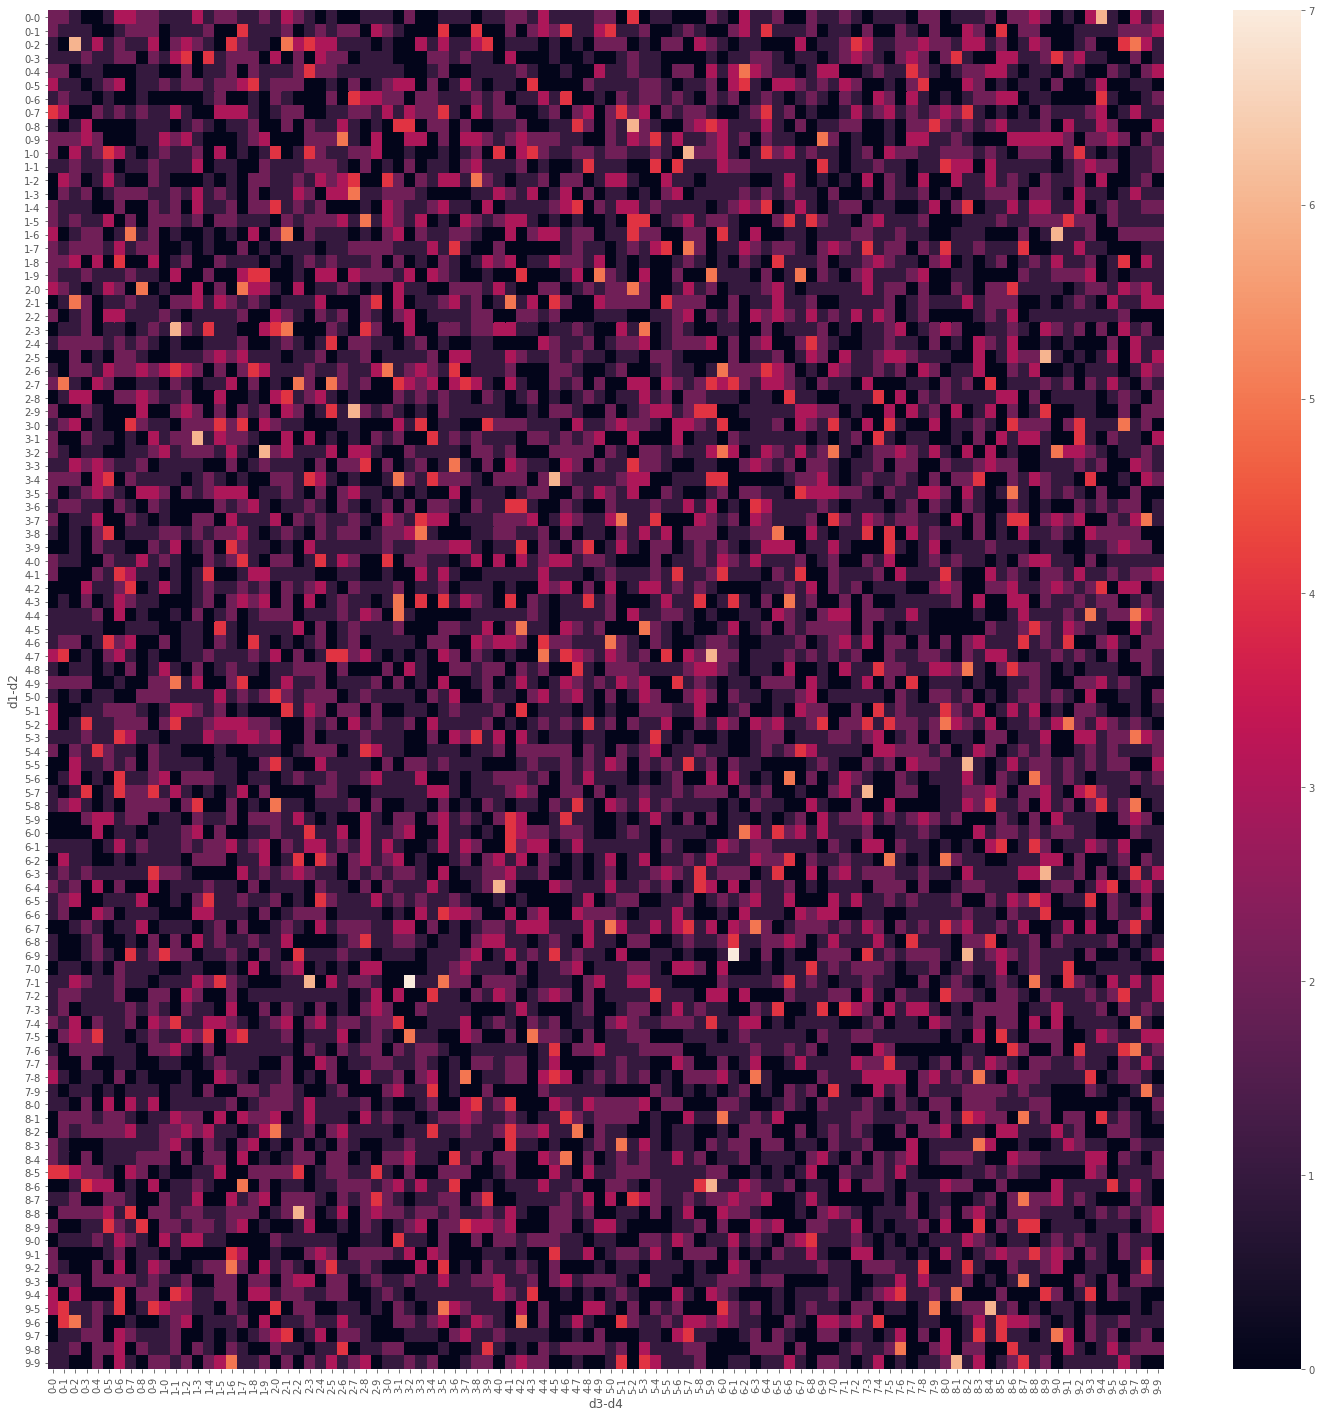

In [71]:
plt.figure(figsize=(25,25))
sns.heatmap(tab.fillna(0))

In [176]:
trace = go.Heatmap(z=tab.fillna(0))
fig = go.Figure(data=[trace],layout={'width':1000, 'height':1000})
fig.show()

In [73]:
#get best combinations
T = tab.fillna(0)

In [74]:
best_idx = np.where(T.where(lambda x: x>=7).isna() == False)
best_idx

(array([69, 71]), array([61, 32]))

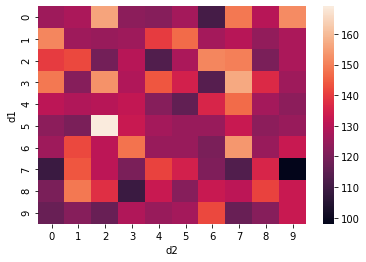

In [104]:

d1_d2 = pd.pivot_table(F,index='d1', values='DrawDate', columns=['d2'],aggfunc='count')
sns.heatmap(d1_d2)

In [ ]:
a

# outcomes

- model try predict average values: 4,5